In [1]:
import pandas as pd
import numpy as np

import numpy.linalg as nla
import numpy.random as nrd

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# Exercise 4.9

Write a computer program to perform a quadratic discriminant
analysis by fitting a separate Gaussian model per class. Try it out on the
vowel data, and compute the misclassification error for the test data. The
data can be found in the book website www-stat.stanford.edu/ElemStatLearn.

# Solution

Some useful function for later,

In [2]:
# Discriminant method
def discriminant_function(x,mu,sig,prob):
    return - np.log(nla.det(sig))/2 - np.diag((x - mu) @ nla.pinv(sig) @ (x - mu).T) + np.log(prob)

def predict(X):
    
    N,_ = X.shape
        
    discriminant = np.empty((0,N))
    for v in vowels:
        posterior_dist = discriminant_function(X,moments[v],covariance[v],prior_prob[v])
        discriminant = np.vstack((discriminant,posterior_dist))
        
    y_predict = np.argmax(discriminant,axis=0) + 1
    
    return y_predict

def error(X,y):
    
    N = y.size
    y_predict = predict(X)
    
    return np.mean(y!=y_predict)

def sqrt_inv_mat(A):
    m,_ = A.shape
    eig_vals, eig_vecs = nla.eig(A)

    A_sqrt_inv = np.zeros((m,m))

    for i in range(m):
        f_val = np.power(eig_vals[i],-1/2)
        eig_vec = eig_vecs[:,i].reshape((m,1))
        eig_vec @ eig_vec.T
        A_sqrt_inv += f_val * eig_vec @ eig_vec.T

    return A_sqrt_inv

## Using Quadratic Discriminant Analysis on vowel dataset

In [3]:
url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train'
vowel_df = pd.read_csv(url_link)
vowel_df.pop('row.names')

url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.test'
test_vowel_df = pd.read_csv(url_link)
test_vowel_df.pop('row.names')

vowel_df.tail()

,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
523,7,-4.065,2.876,-0.856,-0.221,-0.533,0.232,0.855,0.633,-1.452,0.272
524,8,-4.513,4.265,-1.477,-1.090,0.215,0.829,0.342,0.693,-0.601,-0.056
525,9,-4.651,4.246,-0.823,-0.831,0.666,0.546,-0.300,0.094,-1.343,0.185
526,10,-5.034,4.993,-1.633,-0.285,0.398,0.181,-0.211,-0.508,-0.283,0.304
527,11,-4.261,1.827,-0.482,-0.194,0.731,0.354,-0.478,0.050,-0.112,0.321


In [4]:
vowels = sorted(set(vowel_df['y']))

y_train = vowel_df.pop('y').to_numpy()
X_train = vowel_df.to_numpy()

y_test = test_vowel_df.pop('y').to_numpy()
X_test = test_vowel_df.to_numpy()

Here we compute the prior probabilities, the moments, and the cov matrices of the inputs,

In [5]:
N,p = X_train.shape

prior_prob = {}
moments = {}
covariance = {}

for v in vowels:
    relevant_data = y_train == v
    
    Nv = np.sum(relevant_data)
    X_v = X_train[relevant_data]
    mu_v = np.mean(X_v,axis=0)
    sig_v = (X_v - mu_v).T @ (X_v - mu_v)/(Nv-1)
    
    prior_prob[v] = Nv/N
    moments[v] = mu_v
    covariance[v] = sig_v

Training and test errors,

In [6]:
print("Training error: {:.2f}".format(error(X_train,y_train)))
print("Test error: {:.2f}".format(error(X_test,y_test)))

Training error: 0.02
Test error: 0.54


## Playing with visualisation of the data

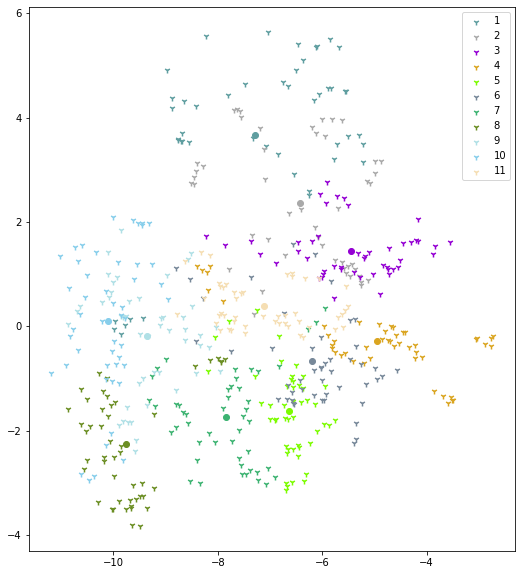

In [7]:
# Preparing the matrix M of moments
M = []
for v in vowels:
    M.append(moments[v])
M = np.array(M)

# Preparing the pooled CM
S = np.zeros((p,p))
norm = 0

for v in vowels:
    Nv = prior_prob[v]*N
    S += (Nv - 1)*covariance[v]
    norm += Nv-1
    
S = S/norm
S_sqrt_inv = sqrt_inv_mat(S)

# We rotate the moment matrix by the above matrix
M_star = M @ S_sqrt_inv

# And we compute the covariance matrix of this matrix (the in-between CM)
B_star = M_star.T @ M_star

# Here we find which directions are the one with higher variance (take the first two to visualise)
B_evals, B_evecs = nla.eig(B_star)

vec = S_sqrt_inv @ B_evecs[:,:2]
Z = (X_train @ vec)

# Select colours for each vowel
cols_list = list(mcolors.CSS4_COLORS.keys())
N_col = len(cols_list)
delta_col = N_col//11
cols = [cols_list[i*delta_col] for i in range(1,12)]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

for v,col in zip(vowels,cols):
    
    # Projections of the input data for each vowel
    x0,x1 = Z[y_train == v].T
    plt.scatter(x0,x1,marker='1',label = str(v),c=col)
    
    # Projection of the associated mean
    m0,m1 = vec.T @ moments[v]
    plt.scatter(m0,m1,marker='o',c=col)
    
plt.legend()
plt.show()